# Natural Language Inference

This Jupyter Notebook fine-tunes `microsoft/xlm-roberta-large` on many NLI datasets.
It includes data loading, preprocessing, data augmentation, model training, evaluation, and visualization.

### Environment

This notebook was executed on a local Jupyter server in a LXC connected to 4 GPUs `NVIDIA XM4 A100 80GB` to train models.

#### Install dependencies

In [1]:
%pip install -qU pandas seaborn matplotlib scikit-learn datasets evaluate
%pip install -qU "transformers[torch]" "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define environment variables
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!export TOKENIZERS_PARALLELISM=false

#### Import libraries

In [3]:
import os
import warnings
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from datasets import Dataset, concatenate_datasets, load_dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments, TrainerCallback

Define some constants depending on the environment and backend.

In [4]:
ROOT_PATH = Path.cwd()
MODEL_DIR = ROOT_PATH / "models"
PRETRAINED_MODEL_NAME = "FacebookAI/xlm-roberta-large"

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = True
    print(f"GPU: {torch.cuda.get_device_name()} (x{torch.cuda.device_count()})")
else:
    device = torch.device("cpu")

local_rank = int(os.environ.get("LOCAL_RANK", -1))
warnings.filterwarnings("ignore", message=".*Was asked to gather along dimension 0.*")

GPU: NVIDIA A100-SXM4-80GB (x4)


### Preprocessing

#### Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

def tokenize(row, max_length=510):
    """Pre-processing class to handle text tokenization."""
    return tokenizer(
        row['premise'], 
        row['hypothesis'],
        padding='max_length', 
        truncation=True, 
        max_length=max_length, # Default: 512 - 2 tokens for CLS and SEP
        return_tensors="pt"    # Return PyTorch tensors
    )

#### Challenge dataset

In [6]:
df = pd.read_csv(ROOT_PATH / "data/train.csv")

# Train-test spliting
challenge_dataset = Dataset.from_pandas(df).train_test_split(test_size=0.3, seed=0)
challenge_train = challenge_dataset['train'].map(tokenize, batched=True)
challenge_val = challenge_dataset['test'].map(tokenize, batched=True)

# Test dataset provided by the Kaggle challenge
df_test = pd.read_csv(ROOT_PATH / "data/test.csv")
challenge_test = Dataset.from_pandas(df_test).map(tokenize, batched=True)

# Inspect the train dataset with 10 random row
df.sample(10)

Map:   0%|          | 0/8484 [00:00<?, ? examples/s]

Map:   0%|          | 0/3636 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

,id,premise,hypothesis,lang_abv,language,label
7534,3366628981,"Upriver, east of Blois, in a huge densely wood...","The woods are full of dangerous creatures, whi...",en,English,1
794,3293210c58,Be sure to look around and compare before buying.,Don't consider and compare before buying.,en,English,2
1875,3456f365b8,oh constantly,I jog constantly,en,English,1
743,fe503f3231,eThe number of deletions was negligible.,The precise number of deletions was 71.,en,English,1
1206,38b89457d6,"In these cases, participants risk losing not o...",Participants have no risk in losing their job ...,en,English,2
6135,19409bfbf1,当出现这种情况时，贷款基金会在其投资余额中牺牲国债证券的利息，而从贷款金额中获得借款基金的利息。,贷款基金始终保证9％的利息。,zh,Chinese,2
3159,30994231ec,Benchmarked by U.S.,The benchmark is notable.,en,English,1
8756,e7538b24d7,hi Cynthia what did you wear to work today,"I was wondering, what did you wear to work tod...",en,English,0
2014,e794080355,کینیت سٹار کا وقت کی پروفائل اس کو قدامت پرست،...,کینتھ سٹار ایک لبرل'شرمیلا اور پرجوش کھلاڑی دی...,ur,Urdu,2
1800,114ad7aa0e,It describes six applications of case study me...,There are just two applications for case study...,en,English,2


Display label distribution: the dataset is evenly distributed across all labels.

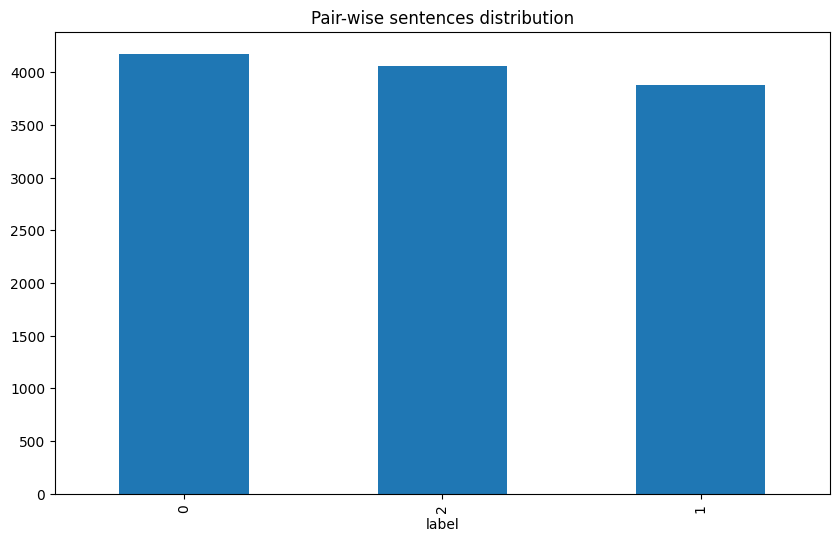

In [6]:
df.label.value_counts().plot(kind="bar", figsize=(10, 6), title="Pair-wise sentences distribution")
plt.show()

However, the dataset predominantly consists of English sentences.

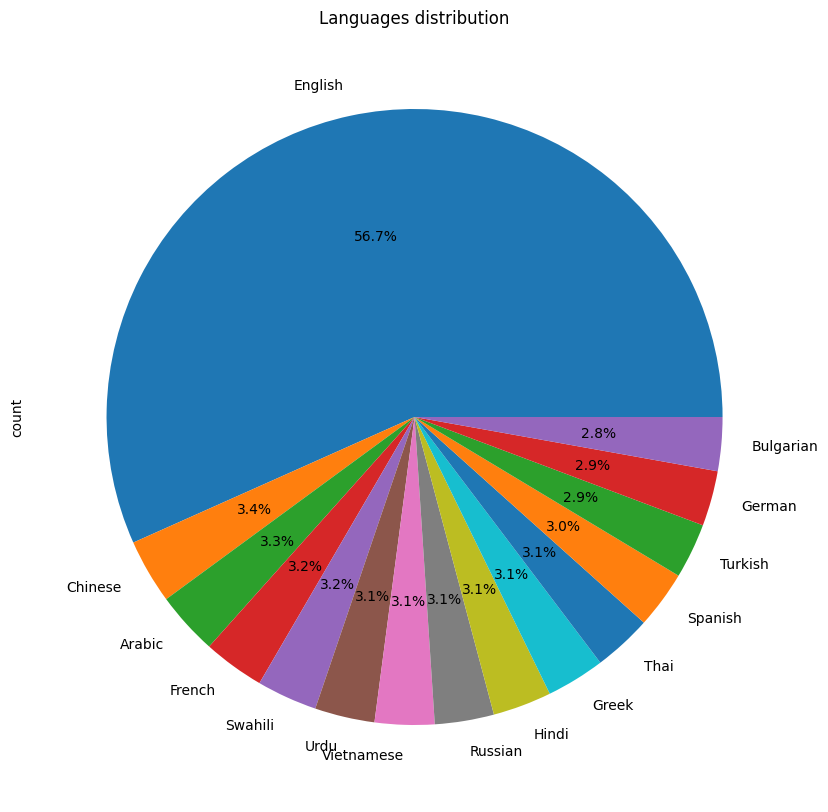

In [7]:
df.language.value_counts().plot(
    kind="pie", 
    figsize=(10, 10), 
    autopct='%1.1f%%', 
    title="Languages distribution"
)
plt.show()

#### MNLI dataset

We use `matched` version of validation and test splits because the dataset from the Challenge seems to match the same genre.

In [7]:
mnli_dataset = load_dataset("nyu-mll/glue", "mnli")
# Preprocess each split
mnli_train = mnli_dataset['train'].map(tokenize, batched=True)
mnli_dev = mnli_dataset['validation_matched'].map(tokenize, batched=True)
mnli_test = mnli_dataset['test_matched'].map(tokenize, batched=True)

#### XNLI dataset

- [XNLI: Evaluating Cross-lingual Sentence Representations](https://aclanthology.org/D18-1269/) (Conneau et al., EMNLP 2018)
- [XNLI Construction Details](https://mayhewsw.github.io/2020/11/26/xnli-details/)

In [8]:
MAX_NUMBER_OF_EXAMPLES = 2_000_000  # Limit the number of examples as the dataset is very large

def load_xnli_datasets(languages: list, split="train"):
    max_dataset_length = MAX_NUMBER_OF_EXAMPLES // len(languages)
    datasets = []
    for lang in languages:
        xnli_lang = load_dataset("facebook/xnli", lang, split=split)
        xnli_lang = xnli_lang.select(range(min(len(xnli_lang), max_dataset_length)))
        xnli_lang = xnli_lang.add_column("lang_abv", [lang] * len(xnli_lang))
        datasets.append(xnli_lang)

    dataset = concatenate_datasets(datasets).shuffle(seed=0)
    return dataset.map(tokenize, batched=True)

# The 'en' train dataset is actually the MNLI train set
languages = ['ar','bg','de','el','es','fr','hi','ru','sw','th','tr','ur','vi','zh']
# Preprocess each split
xnli_train = load_xnli_datasets(languages, split="train")
xnli_val = load_xnli_datasets(languages, split="validation")
xnli_test = load_xnli_datasets(languages, split="test")

Map:   0%|          | 0/1999998 [00:00<?, ? examples/s]

### Model
We use `XLM-RoBERTa` model from `transformers` library and add a classification head on top of it.

In [8]:
import torch.nn as nn
from transformers.models.xlm_roberta.modeling_xlm_roberta import (
    XLMRobertaModel, XLMRobertaForSequenceClassification
)

class XLMRobertaClassificationHeadWithMeanPooling(nn.Module):
    """Custom head for sentence-level classification tasks."""
    def __init__(self, config):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if config.classifier_dropout is not None:
            self.dropout = nn.Dropout(config.classifier_dropout)
        else:
            self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        # Average pooling instead of taking the <s> token (equiv. to [CLS])
        x = self.avg_pool(features.permute(0, 2, 1)).squeeze(-1) 
        x = self.dropout(x)
        x = self.dense(x)
        x = nn.functional.gelu(x)   # Default: torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class XLMRobertaWithMeanPooling(XLMRobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        self.classifier = XLMRobertaClassificationHeadWithMeanPooling(config)
        # Initialize weights and apply final processing
        self.post_init()
        

model = XLMRobertaWithMeanPooling.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=3)
model.to(device)  # Move model to GPU if available

Some weights of XLMRobertaWithMeanPooling were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaWithMeanPooling(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features

### Finetuning

Training and evaluation use the `Trainer` API from the `transformers`. 

These paper helps to choice a strategy for training on multilingual NLI task:
- [How to Fine-Tune BERT for Text Classification](https://arxiv.org/pdf/1905.05583)
- [Unsupervised Cross-lingual Representation Learning at Scale, Facebook AI](https://aclanthology.org/2020.acl-main.747.pdf)
- [Training Dynamics for Curriculum Learning: A Study on Monolingual and Cross-lingual NLU](https://aclanthology.org/2022.emnlp-main.167.pdf).

In [9]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    """Compute accuracy on the validation set."""
    y_pred = np.argmax(eval_pred.predictions, axis=1)
    return {"accuracy": accuracy_score(y_pred, eval_pred.label_ids)}

class FullEvalAtEpochEndCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        control.should_evaluate = True
        return control

#### Training (XNLI)

Finetune the model on the MNLI and XNLI dataset. Enable recommended [Optimizations for A100 GPUs](https://servicedesk.surf.nl/wiki/spaces/WIKI/pages/30668820/Deep+Learning+on+A100+GPUs).

**Architecture:**  
- `xml-roberta-large` pre-trained model from Hugging Face
- Train on 1 EPOCH only: [One Epoch Is All You Need](https://arxiv.org/abs/1906.06669)

In [12]:
XNLI_MODEL_PATH = MODEL_DIR / "xlm-roberta-large-mnli-xnli"

training_args = TrainingArguments(
    output_dir=XNLI_MODEL_PATH,
    eval_strategy='steps',
    save_strategy='steps',
    eval_steps=1000,
    save_steps=10000,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.1,
    bf16=True,  # Use bfloat16 for training (supported on A100 GPUs)
    torch_compile=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    local_rank=local_rank,
    report_to='none',  # Disabling wandb callbacks
)
# Concatenate the MNLI and XNLI datasets
mnli_xnli_train = concatenate_datasets([mnli_train, xnli_train])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mnli_xnli_train,
    eval_dataset=xnli_val,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[FullEvalAtEpochEndCallback()],
)
trainer.train(resume_from_checkpoint=True)

torch.cuda.empty_cache()  # Free some unused memory
# Save the best model and the tokenizer to disk.
trainer.save_model(XNLI_MODEL_PATH)
tokenizer.save_pretrained(XNLI_MODEL_PATH)

Step,Training Loss,Validation Loss,Accuracy
5000,0.603100,0.550588,0.788009
10000,0.578200,0.552192,0.781698
15000,0.546000,0.572966,0.786087
20000,0.512300,0.515901,0.800861
25000,0.490600,0.517712,0.798881
30000,0.457600,0.513739,0.804504
35000,0.436700,0.531361,0.804590
40000,0.417400,0.504258,0.812249
45000,0.411900,0.513142,0.810011
50000,0.392200,0.507306,0.819507


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



('/home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli-xnli/tokenizer_config.json',
 '/home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli-xnli/special_tokens_map.json',
 '/home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli-xnli/sentencepiece.bpe.model',
 '/home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli-xnli/added_tokens.json',
 '/home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli-xnli/tokenizer.json')

Upload the model to Hugging Face Hub

In [ ]:
%pip install -qU huggingface-hub
!huggingface-cli login --token "$HF_TOKEN"

In [ ]:
REPOSITORY_NAME = f"ajayat/xlm-roberta-large-mnli-xnli"

trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

#### Training (Challenge)

In [ ]:
PRETRAINED_MODEL_NAME = "joeddav/xlm-roberta-large-xnli"
MODEL_OUTPUT_DIR = ROOT_PATH / "models/xlm-roberta-large-xnli"

model = XLMRobertaWithMeanPooling.from_pretrained(
    PRETRAINED_MODEL_NAME, 
    hidden_dropout_prob=0.3,           # default 0.1
    attention_probs_dropout_prob=0.3,  # default 0.1
    num_labels=3
).to(device)  # Move model to GPU if available

Define hyperparameters and train the model on the Challenge dataset.

In [ ]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    bf16=True,  # Use bfloat16 for training (supported on A100 GPUs)
    torch_compile=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=challenge_train,
    eval_dataset=challenge_val,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

# Save the best model and the tokenizer to disk.
trainer.save_model(MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(MODEL_OUTPUT_DIR)

Upload the model to HuggingFace Hub. (Optional)

In [ ]:
REPOSITORY_NAME = f"ajayat/xlm-roberta-large-xnli-finetuned"

trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

### Optimization

We use ONNX Runtime as it is more portable than other backends for inference in CPU & GPU.

In [12]:
%pip install -qU onnxruntime-gpu onnxruntime-tools onnxscript "transformers[onnx]" "optimum[onnxruntime]"

Note: you may need to restart the kernel to use updated packages.


#### Quantization

We define a function to export a model to ONNX format and apply some optimizations, such as quantization. We observed a speedup of x5 on CPU.

In [13]:
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic

def export_to_onnx(model, output_dir: Path):
    """Exports a pre-trained model to the ONNX format and quantizes it."""
    # Minimal dummy input for tracing
    dummy_inputs = tokenize(
        dict(premise="This is a premise.", hypothesis="This is a hypothesis."),
    )
    onnx_model_file = output_dir / "model.onnx"
    torch.onnx.export(
        model.cpu().eval(),  # Ensure inference mode
        (dummy_inputs["input_ids"], dummy_inputs["attention_mask"]),
        onnx_model_file.as_posix(),
        input_names=['input_ids', 'attention_mask'],
        output_names=['logits'],
        dynamic_axes={
            "input_ids": {0: "batch_size", 1: "seq_len"},
            "attention_mask": {0: "batch_size", 1: "seq_len"},
            "logits": {0: "batch_size"},
        },
        opset_version=17,  # ONNX version
    )
    quantize_dynamic(onnx_model_file, output_dir / "model_quant.onnx")
    print(f"Model exported and quantized to {onnx_model_file}!")

model_output_dir = MODEL_DIR / "xlm-roberta-large-mnli-xnli"
model = XLMRobertaWithMeanPooling.from_pretrained(model_output_dir, num_labels=3)
# Export and optimize the model
export_to_onnx(model, model_output_dir)

Model exported and quantized to /home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli-xnli/model.onnx!


#### Inference with ONNX

In [14]:
ONNX_MODEL_PATH = model_output_dir / "model.onnx"
sess_options = ort.SessionOptions()
sess_options.intra_op_num_threads = 8
sess_options.inter_op_num_threads = 4

ort_session = ort.InferenceSession(
    ONNX_MODEL_PATH, 
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
    sess_options=sess_options
)

def ort_infer(premise, hypothesis) -> int:
    example = tokenize(dict(premise=premise, hypothesis=hypothesis))
    inputs = dict(
        input_ids=np.array(list(example["input_ids"])).astype(np.int64),
        attention_mask=np.array(list(example["attention_mask"])).astype(np.int64),
    )
    logits = ort_session.run(None, inputs)[0]  # Inference ONNX
    return logits.ravel()

def predictions(dataset: pd.DataFrame):
    logits = [ort_infer(row['premise'], row['hypothesis']) for row in tqdm(dataset)]
    return np.argmax(logits, axis=-1)

2025-04-15 23:05:43.453320329 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 24 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


### Results

#### Evaluation

Evaluate the model and show classification report.

In [17]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

df = challenge_val.to_pandas()
df["prediction"] = predictions(challenge_val) # Use ONNX inference

label_names = ['entailment', 'neutral', 'contradiction']
print(classification_report(df["label"], df["prediction"], digits=3, target_names=label_names))

100%|██████████| 3636/3636 [00:43<00:00, 84.42it/s]

               precision    recall  f1-score   support

   entailment      0.858     0.865     0.862      1263
      neutral      0.830     0.825     0.828      1144
contradiction      0.904     0.902     0.903      1229

     accuracy                          0.865      3636
    macro avg      0.864     0.864     0.864      3636
 weighted avg      0.865     0.865     0.865      3636



Compute accuracy statistics on each language.

In [18]:
def compute_accuracy(df):
    return accuracy_score(df["label"], df["prediction"])

def compute_accuracy_stats(df):
    lang_acc = df.groupby("lang_abv").apply(compute_accuracy, include_groups=False)
    lang_acc["avg"] = lang_acc.mean()
    return pd.DataFrame([lang_acc], index=["accuracy"])

# Show accuracy for each language
compute_accuracy_stats(df).round(2)

lang_abv,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg
accuracy,0.8,0.84,0.88,0.81,0.89,0.91,0.87,0.87,0.8,0.76,0.83,0.82,0.79,0.86,0.85,0.84


Display the confusion matrix using `scikit-learn`.

<Figure size 800x600 with 0 Axes>

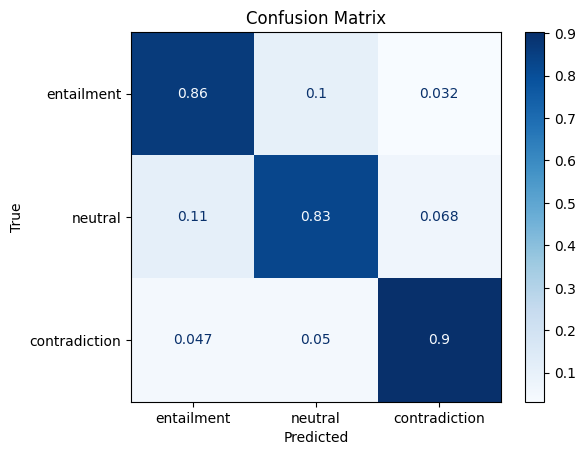

In [19]:
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    df["label"],
    df["prediction"],
    display_labels=label_names,
    cmap='Blues',
    normalize='true',
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Kaggle (Optional)

Create a submission file for the [Kaggle competition](https://www.kaggle.com/competitions/contradictory-my-dear-watson/).

In [20]:
# Create submission csv file
submission = df_test.id.copy().to_frame()
submission["prediction"] = predictions(challenge_test)

submission.to_csv(ROOT_PATH / "data/submission.csv", index=False)
print("Submission file saved.")

100%|██████████| 5195/5195 [01:01<00:00, 84.38it/s]

Submission file saved.


### Conclusion

We first fine-tuned a pre-trained model on the full MNLI dataset, followed by further training on a 1M-example subset of the XNLI dataset. This approach gives a validation accuracy of 0.853 on the challenge dataset.

In a separate experiment, we fine-tuned an already pre-trained HuggingFace model `joeddav/xlm-roberta-large-xnli` directly on the challenge dataset. This method achieved a slightly higher test accuracy of 0.914 on the Kaggle competition dataset, placing us 10th on the leaderboard.

#### Further improvements

- **Finetuning**: finetune `xlm-roberta-large` on the full XNLI dataset, which is 6M examples.